# Plots

/n/home13/chloe00/miniforge3/envs/sys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_143392/285580422.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start s

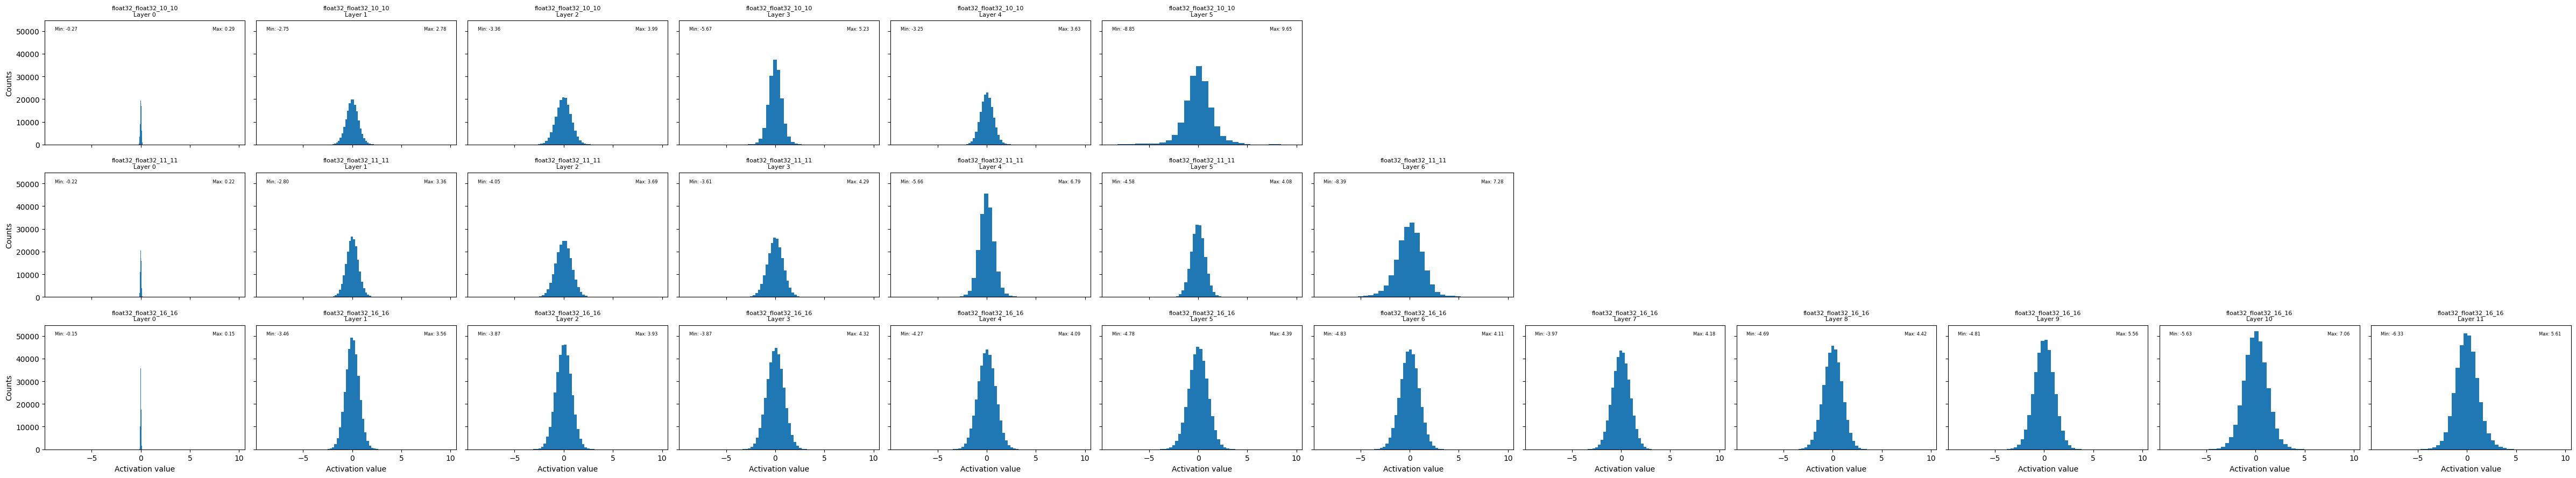

In [1]:
import os, glob, yaml, torch
import matplotlib.pyplot as plt
import numpy as np

from olmo.model   import OLMo, OLMoOutput
from olmo.config  import ModelConfig, ActivationType, BlockType, LayerNormType

# ------------- user settings --------------------------------------------------
DEVICE            = 'cpu'          # 'cuda:2' if you like
BASE_DIR          = f'/n/netscratch/sham_lab/Lab/{user}/ckpts'
PATTERN           = 'float32_float32_*'
N_PER_BUCKET      = 1              # how many runs to keep from each bucket
SMALL_MAX         = 5              # < SMALL_MAX+1  → “small”
MEDIUM_MAX        = 10             # SMALL_MAX+1 .. MEDIUM_MAX → “medium”
# ------------------------------------------------------------------------------

# pass 1: scan configs → bucket by n_layers
buckets = {"small": [], "medium": [], "large": []}

for run_path in sorted(glob.glob(os.path.join(BASE_DIR, PATTERN))):
    cfg_file = os.path.join(run_path, 'latest-unsharded', 'config.yaml')
    if not os.path.isfile(cfg_file):
        continue
    with open(cfg_file) as f:
        cfg  = yaml.safe_load(f)
    n_layers = cfg['model']['n_layers']
    if n_layers <= SMALL_MAX:
        bucket = "small"
    elif n_layers <= MEDIUM_MAX:
        bucket = "medium"
    else:
        bucket = "large"
    if len(buckets[bucket]) < N_PER_BUCKET:
        buckets[bucket].append((run_path, n_layers))

# collapse buckets → selected runs
selected = [item for b in ("small", "medium", "large") for item in buckets[b]]
if not selected:
    raise RuntimeError("No checkpoints matched the pattern and depth criteria.")

# pass 2: load the *selected* models & collect hidden-states
runs = []           # list of (run_name, hidden_states)
max_layers = 0
for run_path, n_layers in selected:
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')

    # build model quickly
    with open(os.path.join(ckpt_dir, 'config.yaml')) as f:
        cfg = yaml.safe_load(f)
    mcfg = cfg['model']
    mcfg.update({
        'activation_type': ActivationType[mcfg['activation_type']],
        'block_type'     : BlockType[mcfg['block_type']],
        'layer_norm_type': LayerNormType[mcfg['layer_norm_type']],
        'init_device'    : 'cpu',
    })
    model = OLMo(ModelConfig(**mcfg)).to(DEVICE).eval()
    state = torch.load(os.path.join(ckpt_dir, 'model.pt'), map_location=DEVICE)
    model.load_state_dict(state)

    # random token batch
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']
    x = torch.randint(0, vocab_size, (1, seq_len), device=DEVICE)

    with torch.no_grad():
        out: OLMoOutput = model(x, output_hidden_states=True, last_logits_only=False)

    runs.append((os.path.basename(run_path), out.hidden_states))
    max_layers = max(max_layers, len(out.hidden_states))

# pass 3: make grid (rows = runs, cols = max_layers)
n_rows = len(runs)
fig, axes = plt.subplots(
    n_rows, max_layers,
    figsize=(4*max_layers, 3*n_rows),
    sharex=True, sharey=True,
    squeeze=False
)

for row, (name, hs) in enumerate(runs):
    for col in range(max_layers):
        ax = axes[row, col]
        if col < len(hs):
            data = hs[col].view(-1).cpu().numpy()
            ax.hist(data, bins=30, density=False)

            # annotate extrema
            ax.text(0.95, 0.95, f"Max: {data.max():.2f}",
                    transform=ax.transAxes, ha='right', va='top', fontsize=6)
            ax.text(0.05, 0.95, f"Min: {data.min():.2f}",
                    transform=ax.transAxes, ha='left',  va='top', fontsize=6)

            ax.set_title(f"{name}\nLayer {col}", fontsize=8)
        else:
            ax.axis('off')   # blank cell

# common axis labels
for ax in axes[-1]:
    ax.set_xlabel("Activation value")
for ax in axes[:,0]:
    ax.set_ylabel("Counts")

plt.tight_layout()
plt.show()


In [1]:
import os, glob, yaml, torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from olmo.model  import OLMo, OLMoOutput
from olmo.config import ModelConfig, ActivationType, BlockType, LayerNormType

# ----------------------------------------------------------- configuration ----
DEVICE   = 'cpu'                       # change to 'cuda:2' if desired
BASE_DIR = '/n/netscratch/sham_lab/Lab/{}/ckpts'
PATTERN  = 'float32_float32_*'

# ----------------------------------------------------------- data containers --
depths, variances, sizes, labels = [], [], [], []   # one entry per point

# ----------------------------------------------------------- main loop --------
for idx, run_path in enumerate(sorted(glob.glob(os.path.join(BASE_DIR, PATTERN)))):
    print(f"Processing: {run_path}")
    if idx>20:
        break # DELETE this when we do our full run, here to save time
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')
    cfg_file = os.path.join(ckpt_dir, 'config.yaml')
    if not os.path.isfile(cfg_file):
        continue

    # ---------- load config & build model (no need to bucket this time)
    with open(cfg_file) as f:
        cfg = yaml.safe_load(f)
    mcfg = cfg['model']
    mcfg.update({
        'activation_type': ActivationType[mcfg['activation_type']],
        'block_type'     : BlockType[mcfg['block_type']],
        'layer_norm_type': LayerNormType[mcfg['layer_norm_type']],
        'init_device'    : 'cpu',
    })
    model = OLMo(ModelConfig(**mcfg)).to(DEVICE).eval()
    state = torch.load(os.path.join(ckpt_dir, 'model.pt'),
                       map_location=DEVICE)
    model.load_state_dict(state)

    # ---------- random token batch (same length as the model’s context window)
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']
    x = torch.randint(0, vocab_size, (1, seq_len), device=DEVICE)

    with torch.no_grad():
        out: OLMoOutput = model(x, output_hidden_states=True,
                                last_logits_only=False)

    hs = out.hidden_states[:-1]          # skip *last* layer
    n_layers = len(hs)
    size     = cfg['params']             # total parameters for color-coding
    name     = os.path.basename(run_path)

    # ---------- accumulate one point per layer
    for depth, h in enumerate(hs):       # depth = 0 .. n_layers-2
        var = h.float().var().item()     # variance over *all* elements
        depths.append(depth)
        variances.append(var)
        sizes.append(size)
        labels.append(name)              # (kept if you want to label points)

# ----------------------------------------------------------- plotting ---------
fig, ax = plt.subplots(figsize=(6,4))

# color-map: log-scale over model size
sizes_np = np.array(sizes, dtype=float)
norm = mpl.colors.LogNorm(vmin=sizes_np.min(), vmax=sizes_np.max())
scatter = ax.scatter(depths, variances,
                     c=sizes_np, cmap='plasma', norm=norm, alpha=0.8,
                     edgecolor='k', linewidths=0.3)

ax.set_xlabel("Layer depth (0 = first transformer block)")
ax.set_ylabel("Activation variance")
ax.set_title("Per-layer activation variance (all runs, last layer skipped)")

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("Model parameters (log scale)")

plt.tight_layout()
plt.show()


/n/home13/chloe00/miniforge3/envs/sys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing: /n/netscratch/sham_lab/Lab/chloe00/ckpts/float32_float32_10_10


/tmp/ipykernel_255773/2935825675.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(os.path.join(ckpt_dir, 'model.pt'),


Processing: /n/netscratch/sham_lab/Lab/chloe00/ckpts/float32_float32_11_11
Processing: /n/netscratch/sham_lab/Lab/chloe00/ckpts/float32_float32_12_12
Processing: /n/netscratch/sham_lab/Lab/chloe00/ckpts/float32_float32_13_13
Processing: /n/netscratch/sham_lab/Lab/chloe00/ckpts/float32_float32_14_14
Processing: /n/netscratch/sham_lab/Lab/chloe00/ckpts/float32_float32_15_15


: 

In [ ]:
import os, glob, yaml, torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.optimize import curve_fit

from olmo.model  import OLMo, OLMoOutput
from olmo.config import ModelConfig, ActivationType, BlockType, LayerNormType

# ----------------------------------------------------------- configuration ----
DEVICE   = 'cuda:0'                       # change to '' if desired
BASE_DIR = '/n/netscratch/sham_lab/Lab/chloe00/ckpts'
PATTERN  = 'float32_float32_*'

# logistic model: v(l) = v_max / (1 + exp(-k * l))
def logistic(l, v_min, v_max, k):
    return v_min + (v_max - v_min)/ (1 + np.exp(-k * l))

# ----------------------------------------------------------- data containers --
depths, variances, labels = [], [], []   # one entry per point

# ----------------------------------------------------------- main loop --------
for idx, run_path in enumerate(sorted(glob.glob(os.path.join(BASE_DIR, PATTERN)))):
    print(f"Processing: {run_path}")
    if idx > 20:  # limit for demonstration; remove for full set
        break
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')
    cfg_file = os.path.join(ckpt_dir, 'config.yaml')
    if not os.path.isfile(cfg_file):
        continue

    # load config & build model
    with open(cfg_file) as f:
        cfg = yaml.safe_load(f)
    mcfg = cfg['model']
    mcfg.update({
        'activation_type': ActivationType[mcfg['activation_type']],
        'block_type'     : BlockType[mcfg['block_type']],
        'layer_norm_type': LayerNormType[mcfg['layer_norm_type']],
        'init_device'    : 'cpu',
    })
    model = OLMo(ModelConfig(**mcfg)).to(DEVICE).eval()
    state = torch.load(os.path.join(ckpt_dir, 'model.pt'), map_location=DEVICE)
    model.load_state_dict(state)

    # random token batch
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']
    x = torch.randint(0, vocab_size, (1, seq_len), device=DEVICE)

    with torch.no_grad():
        out: OLMoOutput = model(x, output_hidden_states=True, last_logits_only=False)

    hs = out.hidden_states[:-1]  # skip final head
    run_label = os.path.basename(run_path)

    # accumulate data per layer
    for depth, h in enumerate(hs):
        depths.append(depth)
        variances.append(h.float().var().item())
        labels.append(run_label)

# convert to arrays
depths = np.array(depths)
variances = np.array(variances)
labels = np.array(labels)
unique_runs = np.unique(labels)

# ----------------------------------------------------------- fitting & plotting ---
fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap('tab10')

for i, run in enumerate(unique_runs):
    mask = (labels == run)
    d_run = depths[mask]
    v_run = variances[mask]

    # initial guesses: v_max ~ max variance, k ~ 1.0
    p0 = [v_run.min(), v_run.max(), 1.0]
    try:
        popt, _ = curve_fit(logistic, d_run, v_run, p0=p0)
    except RuntimeError:
        continue

    # plot scatter and fit curve
    v_min_fit, v_max_fit, k_fit = popt
    color = cmap(i % 10)
    ax.scatter(d_run, v_run, color=color, alpha=0.3, label=None)
    #d_fit = np.linspace(d_run.min(), d_run.max(), 200)
    l_fit = np.linspace(d_run.min(), d_run.max(), 200)
    v_fit = logistic(l_fit, v_min_fit, v_max_fit, k_fit)

    ax.plot(l_fit, v_fit, color=color, label=f"{run}\n$v_{{max}}$={popt[0]:.2f}, k={popt[1]:.2f}")

ax.set_xlabel("Layer depth")
ax.set_ylabel("Activation variance")
ax.set_title("Logistic fits of variance vs depth per run")
ax.legend(fontsize='x-small', loc='best', ncol=2)
plt.tight_layout()
plt.show()


# SCRATCH

In [ ]:
import os
import glob
import yaml
import torch
import matplotlib.pyplot as plt

from olmo.model import OLMo, OLMoOutput
from olmo.config import ModelConfig, ActivationType, BlockType, LayerNormType

DEVICE = 'cuda:2'

BASE_DIR = '/n/netscratch/Lab/ckpts'
PATTERN  = 'fp6_e2m3_bfloat16_*'

for run_path in sorted(glob.glob(os.path.join(BASE_DIR, PATTERN))):
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')
    if not os.path.isdir(ckpt_dir):
        continue

    with open(os.path.join(ckpt_dir, 'config.yaml')) as f:
        cfg = yaml.safe_load(f)

    mcfg = cfg['model'].copy()

    mcfg['activation_type']    = ActivationType[    mcfg['activation_type']   ]
    mcfg['block_type']         = BlockType[         mcfg['block_type']        ]
    mcfg['layer_norm_type']    = LayerNormType[    mcfg['layer_norm_type']   ]
    mcfg['init_device'] = 'cpu'
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']

    model_cfg = ModelConfig(**mcfg)

    model = OLMo(model_cfg)
    model.to('cpu')
    state = torch.load(os.path.join(ckpt_dir, 'model.pt'),
                       map_location='cpu')
    model.load_state_dict(state)
    model.eval() #
    #model.to(DEVICE)


    d_model = mcfg.get('d_model')
    x = torch.randint(
        low=0,
        high=vocab_size,
        size=(1, seq_len),
        dtype=torch.long,
        device='cpu',
    )

    with torch.no_grad():
        out: OLMoOutput = model(
            x,
            output_hidden_states=True,
            last_logits_only=False,
        )

    hs = out.hidden_states  

    n_layers = len(hs)
    fig, axes = plt.subplots(n_layers, 1, figsize=(6, 2*n_layers), sharex=True)
    for idx, h in enumerate(hs):
        data = h.detach().cpu().view(-1).numpy()
        # display max activation value on plot
        max_activation = data.max()
        ax.text(0.95, 0.95, f'Max: {max_activation:.2f}', 
                transform=ax.transAxes, ha='right', va='top', fontsize=8)
        min_activation = data.min()
        ax.text(0.05, 0.95, f'Min: {min_activation:.2f}', 
                transform=ax.transAxes, ha='left', va='top', fontsize=8)
        ax = axes[idx] if n_layers > 1 else axes
        ax.hist(data, bins=100, density=True)
        ax.set_title(f'Run={os.path.basename(run_path)} — Layer {idx}')
        ax.set_ylabel('Density')
    axes[-1].set_xlabel('Activation value')
    plt.tight_layout()
    plt.show()


In [5]:
model

OLMo(
  (transformer): ModuleDict(
    (wte): Embedding(32100, 320)
    (emb_drop): Dropout(p=0.0, inplace=False)
    (ln_f): LayerNorm()
    (blocks): ModuleList(
      (0-4): 5 x OLMoSequentialBlock(
        (dropout): Dropout(p=0.0, inplace=False)
        (k_norm): LayerNorm()
        (q_norm): LayerNorm()
        (act): GELU(approximate='none')
        (attn_out): Linear(in_features=320, out_features=320, bias=False)
        (ff_out): Linear(in_features=1280, out_features=320, bias=False)
        (rotary_emb): RotaryEmbedding()
        (attn_norm): LayerNorm()
        (ff_norm): LayerNorm()
        (att_proj): Linear(in_features=320, out_features=960, bias=False)
        (ff_proj): Linear(in_features=320, out_features=1280, bias=False)
      )
    )
    (ff_out_last): Linear(in_features=320, out_features=32100, bias=False)
  )
)

In [ ]:
import os
import glob
import yaml
import torch
import matplotlib.pyplot as plt

from olmo.model import OLMo, OLMoOutput
from olmo.config import ModelConfig, ActivationType, BlockType, LayerNormType

DEVICE = 'cpu'   # all on CPU for simplicity

BASE_DIR  = '/n/netscratch/Lab/ckpts'
PATTERNS  = [
    'fp6_e2m3_bfloat16_1*',
    'fp6_e2m3_bfloat16_2*',
    #'fp6_e2m3_bfloat16_3*',
] #just use these 3 patterns for now (otherwise there are too many to plot)

run_paths = []
for pat in PATTERNS:
    run_paths.extend(sorted(glob.glob(os.path.join(BASE_DIR, pat))))
run_paths = [rp for rp in run_paths if os.path.isdir(os.path.join(rp, 'latest-unsharded'))]

# 2) For each run, load the model & capture hidden_states
all_hidden_states = []
run_names         = []

for run_path in run_paths:
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')
    with open(os.path.join(ckpt_dir, 'config.yaml')) as f:
        cfg = yaml.safe_load(f)

    # build ModelConfig
    mcfg = cfg['model'].copy()
    mcfg['activation_type'] = ActivationType[mcfg['activation_type']]
    mcfg['block_type']      = BlockType[mcfg['block_type']]
    mcfg['layer_norm_type'] = LayerNormType[mcfg['layer_norm_type']]
    mcfg['init_device']     = 'cpu'

    model_cfg = ModelConfig(**mcfg)
    model     = OLMo(model_cfg).to(DEVICE).eval()

    state = torch.load(os.path.join(ckpt_dir, 'model.pt'), map_location=DEVICE)
    model.load_state_dict(state)

    # prepare a valid random token batch
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']
    x = torch.randint(0, vocab_size, (1, seq_len),
                      dtype=torch.long, device=DEVICE)

    # forward with hidden_states
    with torch.no_grad():
        out: OLMoOutput = model(x, output_hidden_states=True, last_logits_only=False)

    hs = out.hidden_states    # tuple of (batch, seq_len, d_model)
    all_hidden_states.append(hs)
    run_names.append(os.path.basename(run_path))

# 3) Now plot them in a grid (runs × layers)



(21, 5)


IndexError: index 5 is out of bounds for axis 1 with size 5

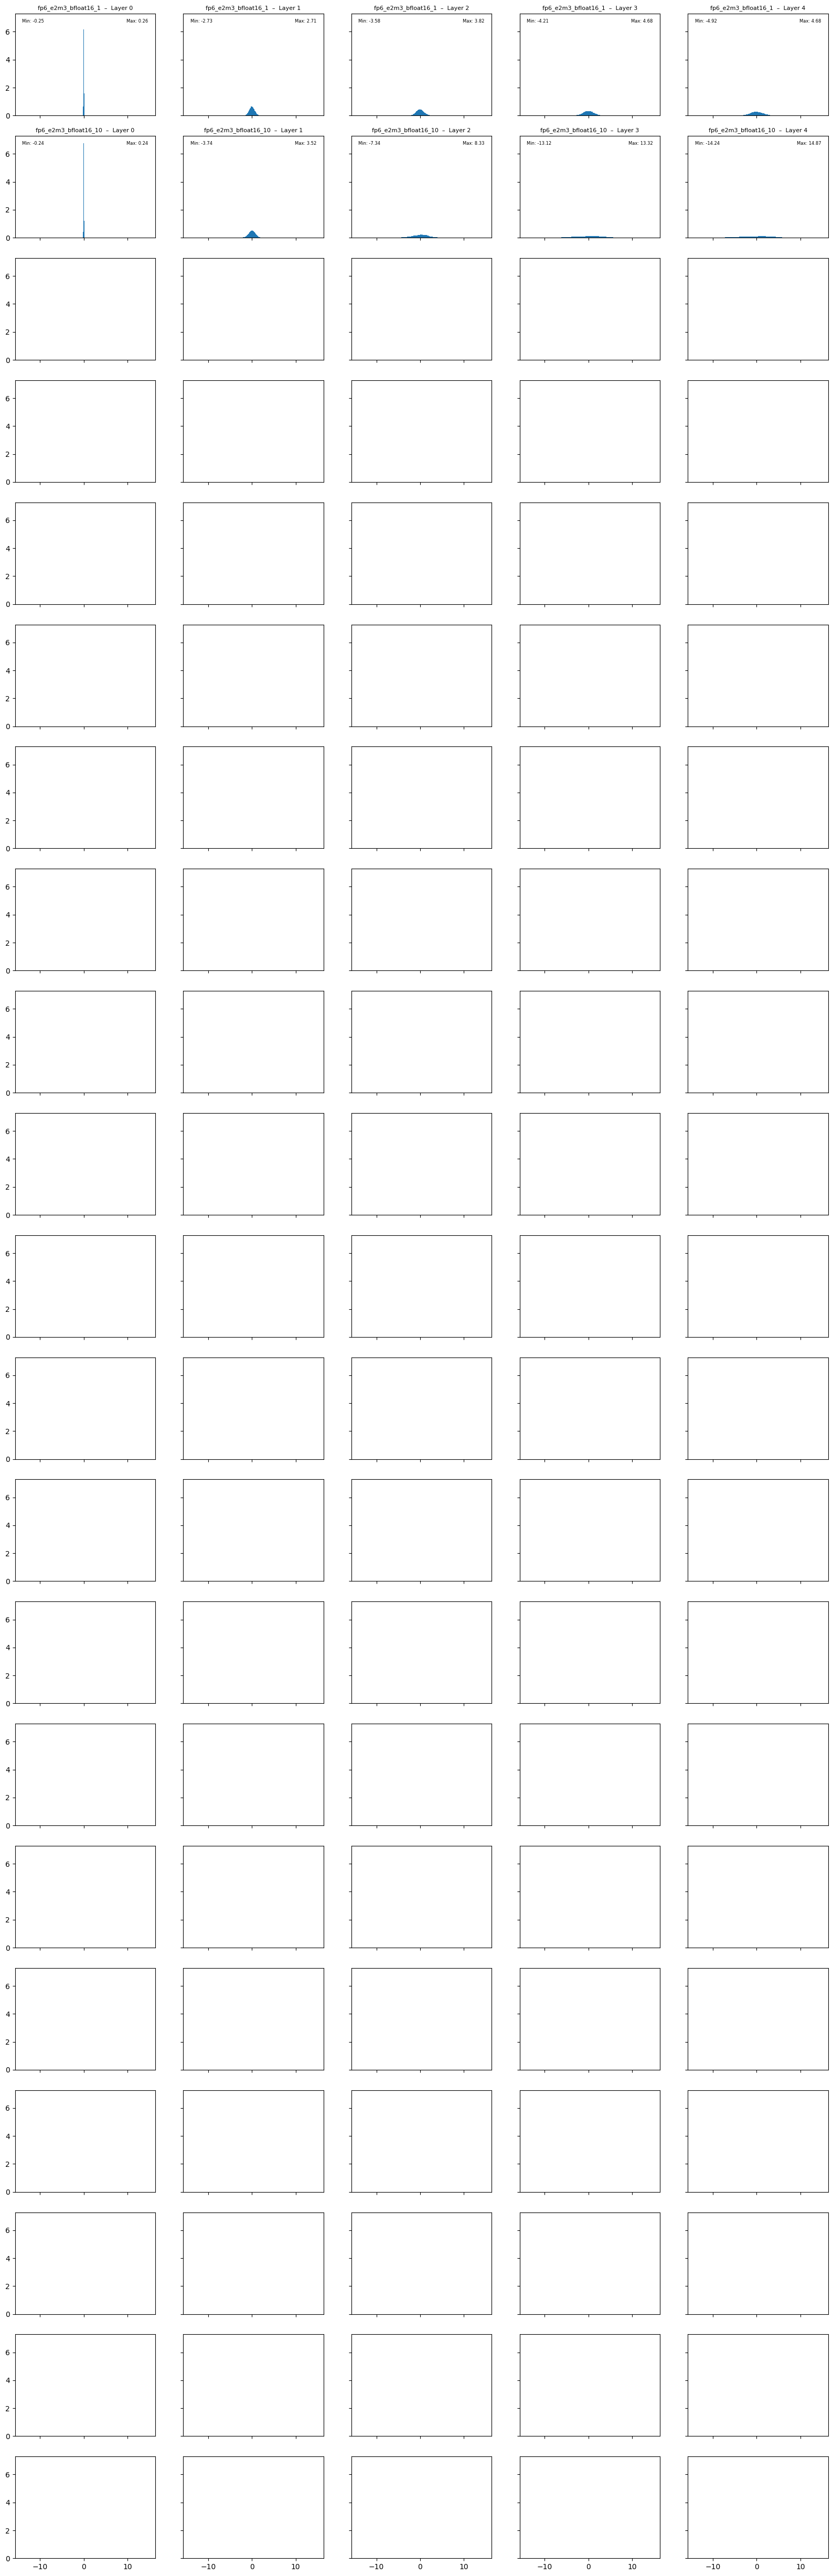

In [28]:
import numpy as np
n_runs   = len(all_hidden_states)
n_layers = len(all_hidden_states[0])   # should be consistent across runs

fig, axes = plt.subplots(
    n_runs,
    n_layers,
    figsize=(4*n_layers, 3*n_runs),
    sharex=True,
    sharey=True,
    squeeze=False,
)
axes = np.array(axes).reshape(n_runs, n_layers)

print(axes.shape)


for i, hs in enumerate(all_hidden_states):
    for j, h in enumerate(hs):
        ax = axes[i, j]
        data = h.view(-1).cpu().numpy()

        # display max/min activation values
        max_val = data.max()
        min_val = data.min()
        ax.text(0.95, 0.95, f'Max: {max_val:.2f}',
                transform=ax.transAxes, ha='right', va='top', fontsize=6)
        ax.text(0.05, 0.95, f'Min: {min_val:.2f}',
                transform=ax.transAxes, ha='left', va='top', fontsize=6)

        ax.hist(data, bins=100, density=True)
        ax.set_title(f'{run_names[i]}  –  Layer {j}', fontsize=8)

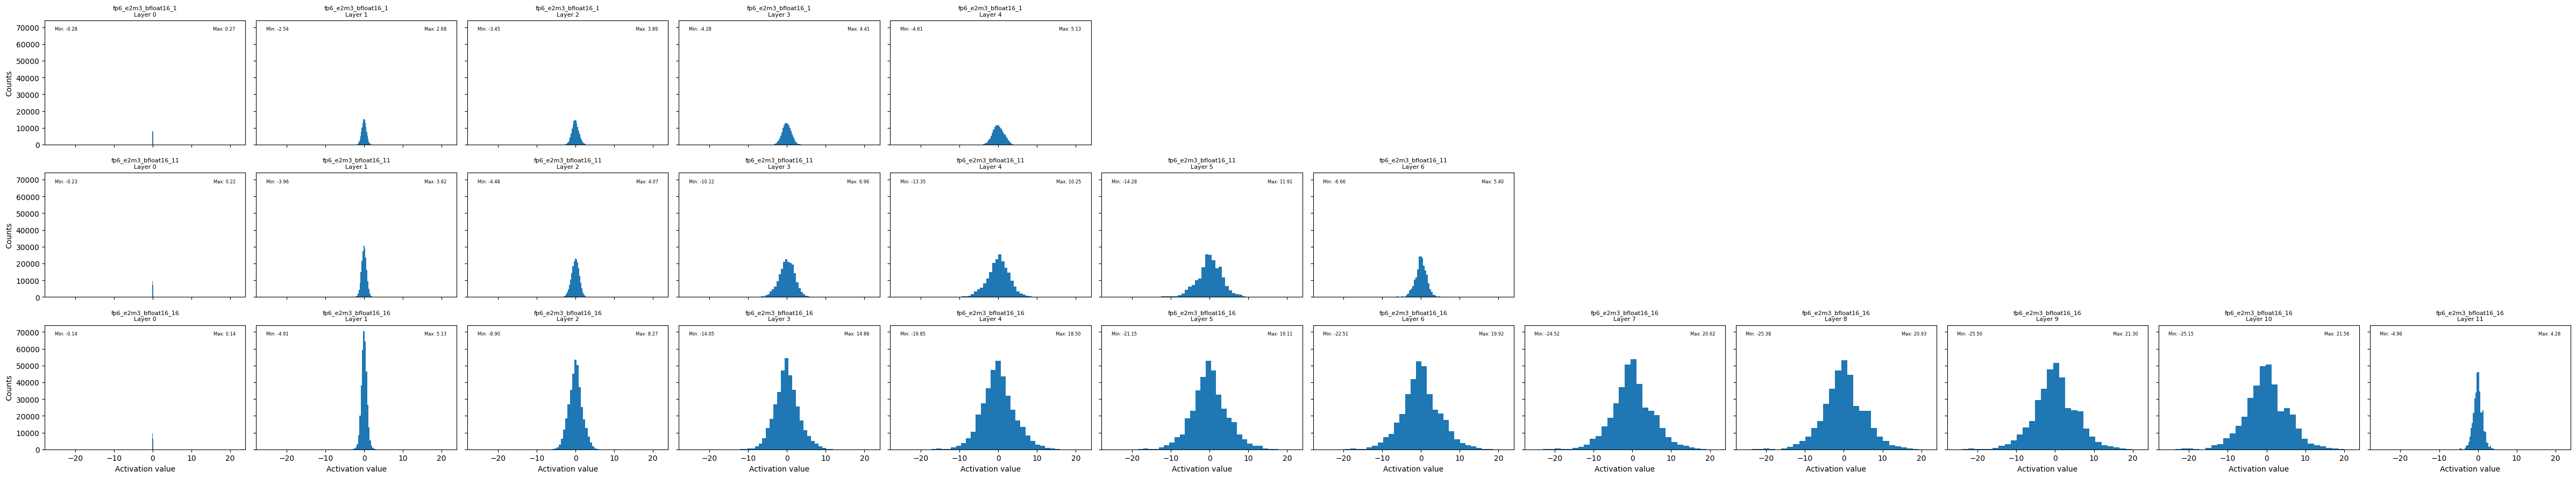

In [33]:
import os, glob, yaml, torch
import matplotlib.pyplot as plt
import numpy as np

from olmo.model   import OLMo, OLMoOutput
from olmo.config  import ModelConfig, ActivationType, BlockType, LayerNormType

# ------------- user settings --------------------------------------------------
DEVICE            = 'cpu'          # 'cuda:2' if you like
BASE_DIR          = '/n/netscratch/Lab/ckpts'
PATTERN           = 'fp6_e2m3_bfloat16_*'
N_PER_BUCKET      = 1              # how many runs to keep from each bucket
SMALL_MAX         = 5              # < SMALL_MAX+1  → “small”
MEDIUM_MAX        = 10             # SMALL_MAX+1 .. MEDIUM_MAX → “medium”
# ------------------------------------------------------------------------------

# pass 1: scan configs → bucket by n_layers
buckets = {"small": [], "medium": [], "large": []}

for run_path in sorted(glob.glob(os.path.join(BASE_DIR, PATTERN))):
    cfg_file = os.path.join(run_path, 'latest-unsharded', 'config.yaml')
    if not os.path.isfile(cfg_file):
        continue
    with open(cfg_file) as f:
        cfg  = yaml.safe_load(f)
    n_layers = cfg['model']['n_layers']
    if n_layers <= SMALL_MAX:
        bucket = "small"
    elif n_layers <= MEDIUM_MAX:
        bucket = "medium"
    else:
        bucket = "large"
    if len(buckets[bucket]) < N_PER_BUCKET:
        buckets[bucket].append((run_path, n_layers))

# collapse buckets → selected runs
selected = [item for b in ("small", "medium", "large") for item in buckets[b]]
if not selected:
    raise RuntimeError("No checkpoints matched the pattern and depth criteria.")

# pass 2: load the *selected* models & collect hidden-states
runs = []           # list of (run_name, hidden_states)
max_layers = 0
for run_path, n_layers in selected:
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')

    # build model quickly
    with open(os.path.join(ckpt_dir, 'config.yaml')) as f:
        cfg = yaml.safe_load(f)
    mcfg = cfg['model']
    mcfg.update({
        'activation_type': ActivationType[mcfg['activation_type']],
        'block_type'     : BlockType[mcfg['block_type']],
        'layer_norm_type': LayerNormType[mcfg['layer_norm_type']],
        'init_device'    : 'cpu',
    })
    model = OLMo(ModelConfig(**mcfg)).to(DEVICE).eval()
    state = torch.load(os.path.join(ckpt_dir, 'model.pt'), map_location=DEVICE)
    model.load_state_dict(state)

    # random token batch
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']
    x = torch.randint(0, vocab_size, (1, seq_len), device=DEVICE)

    with torch.no_grad():
        out: OLMoOutput = model(x, output_hidden_states=True, last_logits_only=False)

    runs.append((os.path.basename(run_path), out.hidden_states))
    max_layers = max(max_layers, len(out.hidden_states))

# pass 3: make grid (rows = runs, cols = max_layers)
n_rows = len(runs)
fig, axes = plt.subplots(
    n_rows, max_layers,
    figsize=(4*max_layers, 3*n_rows),
    sharex=True, sharey=True,
    squeeze=False
)

for row, (name, hs) in enumerate(runs):
    for col in range(max_layers):
        ax = axes[row, col]
        if col < len(hs):
            data = hs[col].view(-1).cpu().numpy()
            ax.hist(data, bins=30, density=False)

            # annotate extrema
            ax.text(0.95, 0.95, f"Max: {data.max():.2f}",
                    transform=ax.transAxes, ha='right', va='top', fontsize=6)
            ax.text(0.05, 0.95, f"Min: {data.min():.2f}",
                    transform=ax.transAxes, ha='left',  va='top', fontsize=6)

            ax.set_title(f"{name}\nLayer {col}", fontsize=8)
        else:
            ax.axis('off')   # blank cell

# common axis labels
for ax in axes[-1]:
    ax.set_xlabel("Activation value")
for ax in axes[:,0]:
    ax.set_ylabel("Counts")

plt.tight_layout()
plt.show()


In [ ]:
import os, glob, yaml, torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from olmo.model  import OLMo, OLMoOutput
from olmo.config import ModelConfig, ActivationType, BlockType, LayerNormType

# ----------------------------------------------------------- configuration ----
DEVICE   = 'cpu'                       # change to 'cuda:2' if desired
BASE_DIR = '/n/netscratch/{}/Lab/{}/ckpts'
PATTERN  = 'fp6_e2m3_bfloat16_*'

# ----------------------------------------------------------- data containers --
depths, variances, sizes, labels = [], [], [], []   # one entry per point

# ----------------------------------------------------------- main loop --------
for idx, run_path in enumerate(sorted(glob.glob(os.path.join(BASE_DIR, PATTERN)))):
    print(f"Processing: {run_path}")
    if idx>12:
        break # DELETE this when we do our full run, here to save time
    ckpt_dir = os.path.join(run_path, 'latest-unsharded')
    cfg_file = os.path.join(ckpt_dir, 'config.yaml')
    if not os.path.isfile(cfg_file):
        continue

    # ---------- load config & build model (no need to bucket this time)
    with open(cfg_file) as f:
        cfg = yaml.safe_load(f)
    mcfg = cfg['model']
    mcfg.update({
        'activation_type': ActivationType[mcfg['activation_type']],
        'block_type'     : BlockType[mcfg['block_type']],
        'layer_norm_type': LayerNormType[mcfg['layer_norm_type']],
        'init_device'    : 'cpu',
    })
    model = OLMo(ModelConfig(**mcfg)).to(DEVICE).eval()
    state = torch.load(os.path.join(ckpt_dir, 'model.pt'),
                       map_location=DEVICE)
    model.load_state_dict(state)

    # ---------- random token batch (same length as the model’s context window)
    seq_len    = mcfg['context_length']
    vocab_size = mcfg['vocab_size']
    x = torch.randint(0, vocab_size, (1, seq_len), device=DEVICE)

    with torch.no_grad():
        out: OLMoOutput = model(x, output_hidden_states=True,
                                last_logits_only=False)

    hs = out.hidden_states[:-1]          # skip *last* layer
    n_layers = len(hs)
    size     = cfg['params']             # total parameters for color-coding
    name     = os.path.basename(run_path)

    # ---------- accumulate one point per layer
    for depth, h in enumerate(hs):       # depth = 0 .. n_layers-2
        var = h.float().var().item()     # variance over *all* elements
        depths.append(depth)
        variances.append(var)
        sizes.append(size)
        labels.append(name)              # (kept if you want to label points)

# ----------------------------------------------------------- plotting ---------
fig, ax = plt.subplots(figsize=(6,4))

# color-map: log-scale over model size
sizes_np = np.array(sizes, dtype=float)
norm = mpl.colors.LogNorm(vmin=sizes_np.min(), vmax=sizes_np.max())
scatter = ax.scatter(depths, variances,
                     c=sizes_np, cmap='plasma', norm=norm, alpha=0.8,
                     edgecolor='k', linewidths=0.3)

ax.set_xlabel("Layer depth (0 = first transformer block)")
ax.set_ylabel("Activation variance")
ax.set_title("Per-layer activation variance (all runs, last layer skipped)")

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("Model parameters (log scale)")

plt.tight_layout()
plt.show()
